# Judgement prediction using machine learning

# Data preparation

In [1]:
import pandas as pd

dataset = pd.read_csv("hf://datasets/glnmario/ECHR/ECHR_Dataset.csv")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
vectorizer = TfidfVectorizer()

df = dataset.drop(['partition', 'itemid', 'docname', 'conclusion', 'languageisocode'], axis=1)
pre_X = df.drop(['binary_judgement'], axis = 1)
Y = dataset['binary_judgement']

pre_X_one_hot = pre_X.drop(['text', 'date', 'importance'], axis = 1)
pre_X_numeric = pre_X[['date', 'importance']]
pre_X_vec = pre_X['text']

X_encoded = pd.get_dummies(pre_X_one_hot)
X_vec = vectorizer.fit_transform(pre_X_vec)

X_encoded_sparse = csr_matrix(X_encoded.values)
pre_X_numeric_sparse = csr_matrix(pre_X_numeric.values)

X = hstack([X_vec, X_encoded_sparse, pre_X_numeric_sparse])

# Train-test split

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_vec, Y, test_size=0.5, random_state=42)

# Models fitting

In [4]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(solver='saga', max_iter=1000)
model_lr.fit(X_train, y_train)

/Users/ww.jedrzej/miniconda3/envs/ncn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, solver='saga')

In [5]:
from sklearn.tree import DecisionTreeClassifier

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train_dense, y_train)

DecisionTreeClassifier()

In [6]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.fit(X_train_2, y_train_2)

MultinomialNB()

Confusion Matrix - Logistic Regression


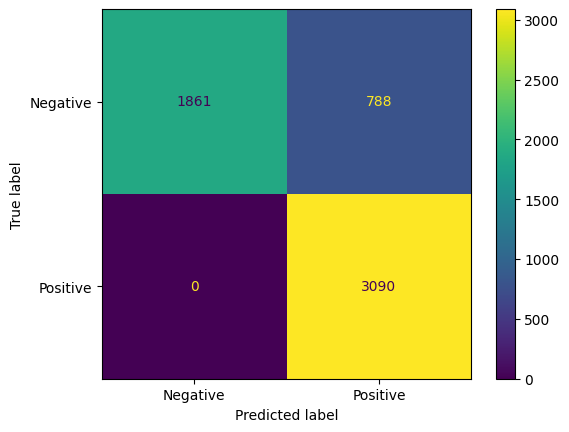

Confusion Matrix - Decision Tree


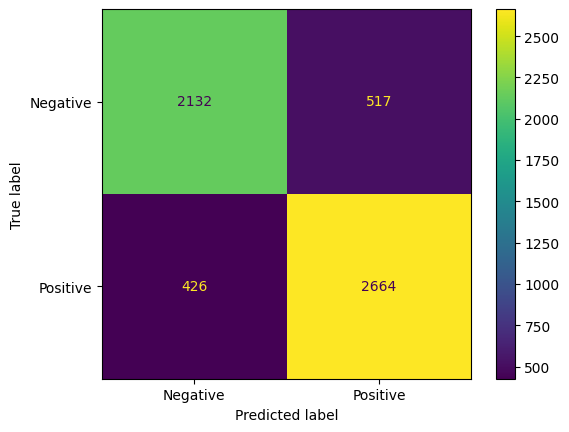

Confusion Matrix - Naive Bayes


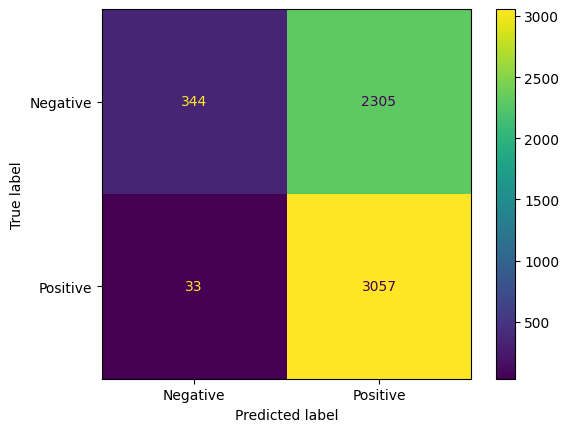

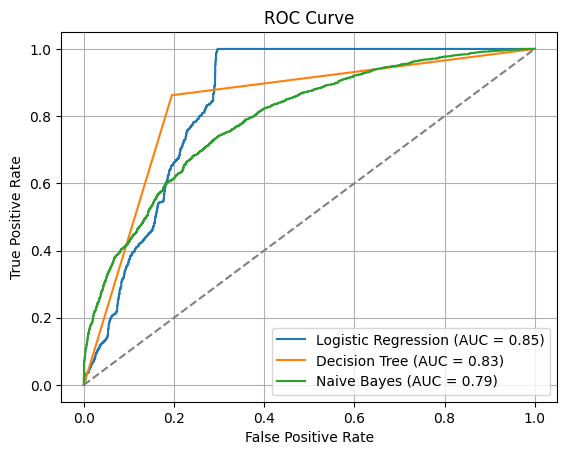

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_lr = model_lr.predict(X_test)
y_pred_tree = model_tree.predict(X_test_dense)
y_pred_nb = model_nb.predict(X_test_2)

y_prob_lr = model_lr.predict_proba(X_test)[:, 1]
y_prob_tree = model_tree.predict_proba(X_test_dense)[:, 1]
y_prob_nb = model_nb.predict_proba(X_test_2)[:, 1]

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_nb = confusion_matrix(y_test_2, y_pred_nb)

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Negative", "Positive"])
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Negative", "Positive"])
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["Negative", "Positive"])

print("Confusion Matrix - Logistic Regression")
disp_lr.plot()
plt.show()

print("Confusion Matrix - Decision Tree")
disp_tree.plot()
plt.show()

print("Confusion Matrix - Naive Bayes")
disp_nb.plot()
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
fpr_nb, tpr_nb, _ = roc_curve(y_test_2, y_prob_nb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_tree = auc(fpr_tree, tpr_tree)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # linia losowa
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Confusion Matrix - Random Classifier


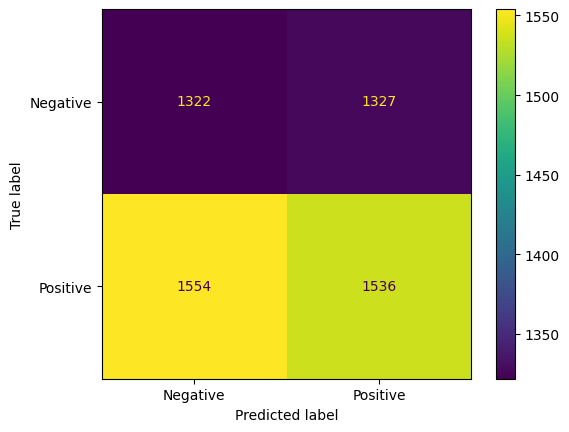

Confusion Matrix - Constant Classifier (all 1)


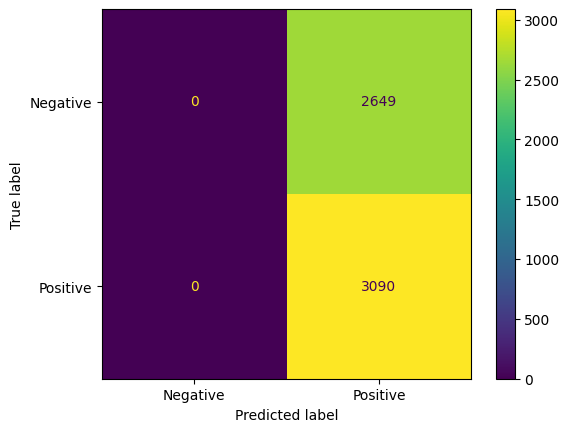

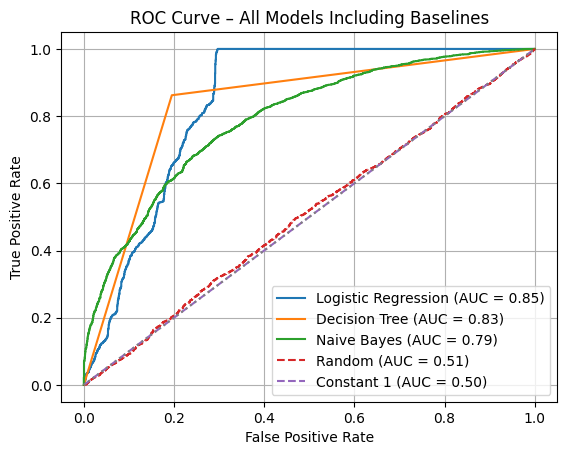

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

np.random.seed(42)
y_pred_random = np.random.randint(0, 2, size=len(y_test))
y_prob_random = np.random.rand(len(y_test))

cm_random = confusion_matrix(y_test, y_pred_random)
disp_random = ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=["Negative", "Positive"])
print("Confusion Matrix - Random Classifier")
disp_random.plot()
plt.show()

fpr_random, tpr_random, _ = roc_curve(y_test, y_prob_random)
auc_random = auc(fpr_random, tpr_random)

y_pred_const = np.ones(len(y_test), dtype=int)
y_prob_const = np.ones(len(y_test))

cm_const = confusion_matrix(y_test, y_pred_const)
disp_const = ConfusionMatrixDisplay(confusion_matrix=cm_const, display_labels=["Negative", "Positive"])
print("Confusion Matrix - Constant Classifier (all 1)")
disp_const.plot()
plt.show()

fpr_const, tpr_const, _ = roc_curve(y_test, y_prob_const)
auc_const = auc(fpr_const, tpr_const)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(fpr_random, tpr_random, label=f'Random (AUC = {auc_random:.2f})', linestyle='--')
plt.plot(fpr_const, tpr_const, label=f'Constant 1 (AUC = {auc_const:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – All Models Including Baselines')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [9]:
import gc

del X_train, X_test, X_train_dense, X_test_dense
del y_train, y_test
del X_encoded_sparse, pre_X_numeric_sparse

In [10]:
import pandas as pd
import numpy as np

X_dense = X.toarray()

dataset['logistic_prediction'] = model_lr.predict(X)
dataset['tree_prediction'] = model_tree.predict(X_dense)
dataset['bayes_prediction'] = model_nb.predict(X_vec)

np.random.seed(42)
dataset['random_prediction'] = np.random.randint(0, 2, size=len(dataset))
dataset['attorney_prediction'] = np.ones(len(dataset), dtype=int)  # stała 1

dataset.to_excel("judgement_predictions.xlsx", index=False)
